在这一节中，我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。
我们将只使用张量和自动求导。

In [22]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

我们将根据带有噪声的线性模型构造一个人造数据集。我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。
线性模型参数 $w=[2,-3,4]^T$ $b=4.2$ 噪声项 $\epsilon$ 生成数据集和标签 $y=Xw+b+\epsilon$
标准差0.01
生成数据集：

In [23]:
def synthetic_data(w,b,num_examples): #@save
    X=torch.normal(0,1,(num_examples,len(w))) #高斯分布的随机数（均值，标准差，形状）
    
    y=torch.matmul(X,w)+b#矩阵乘法
    #真实
    y+=torch.normal(0,0.01,y.shape)
    #扰动
    return X,y.reshape((-1,1))

In [24]:
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)
print(features)

tensor([[-1.4447,  0.9906],
        [ 1.3177,  0.2873],
        [ 1.0483, -3.0069],
        ...,
        [ 0.1100, -0.2881],
        [ 0.7071,  0.1867],
        [-1.5801,  1.3232]])


features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值
特征——输入
标签——输出或目标

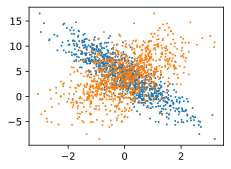

In [25]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
d2l.plt.scatter(features[:, (0)].detach().numpy(), labels.detach().numpy(), 1)
#分别固定x1和x2不变，得到的就是直线

读取数据集
训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。
定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成
大小为batch_size的小批量。每个小批量包含一组特征和标签

In [26]:
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)#索引打乱顺序
    for i in range(0,num_examples,batch_size):#打乱后的按照顺序分块
        batch_indices=torch.tensor(
            indices[i:min(i+batch_size,num_examples)]
        )
        yield features[batch_indices],labels[batch_indices]

我们利用GPU并行运算的优势，处理合理大小的“小批量”。每个样本都可以并行地进行模型计算，且
每个样本损失函数的梯度也可以被并行计算。

在 PyTorch 里，张量可以用「张量索引」来取子集
```python

features = torch.tensor([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0],
    [7.0, 8.0]
])  # (4,2)

batch_indices = torch.tensor([2, 0])  # 取第3行和第1行
```

上面实现的迭代对教学来说
很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。例如，它要求我们将所有数据加载到内存中，并
执行大量的随机内存访问。在深度学习框架中实现的内置迭代器效率要高得多，它可以处理存储在文件中的
数据和数据流提供的数据。

在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要**先有一些参数**。在下面的代码中，我
们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [27]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

须定义模型，将模型的输入和参数同模型的输出关联起来.
要计算线性模型的输出，我们只需计算输入特征X和模型权重w的矩阵‐向量乘法后加上偏置b。
广播机制：当我们用一个向量加一个标量时，标量会被加到向量的每个
分量上。

In [28]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

$\frac{1}{2} \bigl(\hat{y}^{(i)} - y^{(i)}\bigr)^2$
损失函数


In [29]:
def squared_loss(y_hat,y):
    # reshape函数用于确保y的形状与y_hat一致，便于进行元素级的减法运算
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 优化算法
小批量随机梯度下降。
在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。接下来，朝着减少损失
的方向更新我们的参数。

lr:学习率，每一步更新的大小
batch_size：步长

with 背后依赖对象实现了 上下文管理协议，即实现了：

__enter__()：进入 with 块时会执行

__exit__()：离开 with 块时会执行（无论是否报错）

所以在 with torch.no_grad(): 中：

__enter__ 让 PyTorch 暂停梯度计算

__exit__ 在代码块结束时恢复正常的梯度计算

In [30]:
def sgd(params,lr,batch_size):
    with torch.no_grad(): # 在更新参数时不需要计算梯度（避免影响 autograd 的计算图）
        for param in params:
            param -= lr*param.grad/batch_size # 参数更新规则：θ ← θ - (学习率 × 梯度均值)
            param.grad.zero_() #PyTorch 默认梯度是累加的。每次更新完要清零，否则新一轮梯度会叠加在旧梯度上，导致更新出错。

# 训练
### 非常重要
每次迭代，读取一小批量训练样本，通过模型获得一组预测。
计算完损失，开始反向传播，存储每个参数的梯度。
调用优化算法sgd更新模型参数。

即：循环：
- 初始化参数
- 重复：
    - 反向传播：利用链式法则，计算损失对所有参数的梯度。计算梯度
    - 更新$(\mathbf{w}, b) \;\leftarrow\; (\mathbf{w}, b) - \mu g$ 

在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集，并将训练数据集中所有样本都使用
一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs和学习率lr都是**超参数**，分别设
为3和0.03。设置超参数很棘手，需要通过反复试验进行调整。

In [31]:
lr = 0.03
num_epochs = 3
net = linreg #net即network为要训练的模型
loss = squared_loss
batch_size=10

In [32]:
for epoch in range(num_epochs):                       # 外层循环：迭代多个训练轮次
    for X, y in data_iter(batch_size, features, labels):  # 内层循环：每次取一个小批量 (X, y)
        l = loss(net(X, w, b), y)                    # 前向传播：计算预测值并求损失
        l.sum().backward()                           # 反向传播：根据损失计算梯度
        sgd([w, b], lr, batch_size)                  # 参数更新：用小批量 SGD 更新 w 和 b

    with torch.no_grad():                            # 不计算梯度，做评估
        train_l = loss(net(features, w, b), labels)  # 整个数据集上的训练损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 0.047299
epoch 2, loss 0.000191
epoch 3, loss 0.000051


In [33]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')
print(f'预测的b：{b}，\n预测的w：{w}')
print(f'实际b：{true_b}，\nw{true_w}')   

w的估计误差: tensor([ 0.0005, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)
预测的b：tensor([4.1995], requires_grad=True)，
预测的w：tensor([[ 1.9995],
        [-3.3996]], requires_grad=True)
实际b：4.2，
wtensor([ 2.0000, -3.4000])


hw

In [34]:
#1 权重为0
true_w_zero=torch.tensor([0.0,0.0])
true_b=4.2
features,labels=synthetic_data(true_w_zero,true_b,1000)

w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
for epoch in range(num_epochs):                       # 外层循环：迭代多个训练轮次
    for X, y in data_iter(batch_size, features, labels):  # 内层循环：每次取一个小批量 (X, y)
        l = loss(net(X, w, b), y)                    # 前向传播：计算预测值并求损失
        l.sum().backward()                           # 反向传播：根据损失计算梯度
        sgd([w, b], lr, batch_size)                  # 参数更新：用小批量 SGD 更新 w 和 b

    with torch.no_grad():                            # 不计算梯度，做评估
        train_l = loss(net(features, w, b), labels)  # 整个数据集上的训练损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


print(f'预测的b：{b}，\n预测的w：{w}')


epoch 1, loss 0.020154
epoch 2, loss 0.000095
epoch 3, loss 0.000049
预测的b：tensor([4.2000], requires_grad=True)，
预测的w：tensor([[ 2.4279e-04],
        [-4.2252e-05]], requires_grad=True)


In [35]:
# 6 学习率
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)
def learn(lr_1):
    for epoch in range(num_epochs):                       # 外层循环：迭代多个训练轮次
        for X, y in data_iter(batch_size, features, labels):  # 内层循环：每次取一个小批量 (X, y)
            l = loss(net(X, w, b), y)                    # 前向传播：计算预测值并求损失
            l.sum().backward()                           # 反向传播：根据损失计算梯度
            sgd([w, b], lr_1, batch_size)                  # 参数更新：用小批量 SGD 更新 w 和 b

        with torch.no_grad():                            # 不计算梯度，做评估
            train_l = loss(net(features, w, b), labels)  # 整个数据集上的训练损失
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    print(f'预测的b：{b}，\n预测的w：{w}')
learn(0.01)
print()
learn(0.1)
print()
learn(0.5)

epoch 1, loss 1.079693
epoch 2, loss 0.156031
epoch 3, loss 0.022577
预测的b：tensor([4.1924], requires_grad=True)，
预测的w：tensor([[ 1.8877],
        [-3.2147]], requires_grad=True)

epoch 1, loss 0.000053
epoch 2, loss 0.000053
epoch 3, loss 0.000053
预测的b：tensor([4.1991], requires_grad=True)，
预测的w：tensor([[ 2.0012],
        [-3.3999]], requires_grad=True)

epoch 1, loss 0.000056
epoch 2, loss 0.000071
epoch 3, loss 0.000054
预测的b：tensor([4.2007], requires_grad=True)，
预测的w：tensor([[ 1.9990],
        [-3.4004]], requires_grad=True)
